## Грузим задание

In [137]:
! wget -nc https://github.com/artonson/hse-stat-course-2018/raw/master/homework-handouts/homework-3.pdf

Файл «homework-3.pdf» уже существует — не загружается.



### Грузим данные

In [138]:
! wget -nc -P data/ https://raw.githubusercontent.com/artonson/hse-stat-course-2018/master/homework-handouts/passengercarmileage.txt

Файл «data/passengercarmileage.txt» уже существует — не загружается.



# Задание 1.

Заметим, что $E[X] = \lambda, D[X] = \lambda$. Введем оценку $\hat\lambda = \overline X$ -- ассимптотичски нормальная оценка.
$$
W = \dfrac{\hat\lambda - \lambda_0}{\hat{se}}
$$
$$
\hat{se} = \sqrt{\frac{\hat{\lambda}}{n}}
$$
$H_0$ отклоняем, если $|W| > z_{\alpha/2}$

In [139]:
import numpy as np
import scipy.stats
from tqdm import tqdm_notebook as tqdm

In [140]:
lambda_0 = 1
n = 20
alpha = 0.05

In [141]:
def h0_accept():
    X = np.random.poisson(lam=lambda_0, size=n)
    W = (X.mean() - lambda_0) / np.sqrt(X.mean() / n)
    #print(W)
    z_alpha2 = scipy.stats.norm.interval(1 - alpha)[1]
    #print(z_alpha2)
    return not(np.abs(W) > z_alpha2)

In [142]:
n_exp = 10**4
count_accepted = 0
for i in tqdm(range(n_exp)):
    count_accepted += h0_accept()
print('Доля экспериментов с отклоненной H0 = %f' % (1 - count_accepted / n_exp))


Доля экспериментов с отклоненной H0 = 0.051000


##### Ну, конечно, доля получилулась близка к $\alpha$. Мы же отлично знаем мат. статистику, а она говорит, что доля ошибок первого сходится к $\alpha$ 

# Задание 2

# Задание 3

In [143]:
import pandas as pd

In [144]:
df = pd.read_csv('data/passengercarmileage.txt', sep='\t', index_col=0)
df[:5]

,VOL,HP,MPG,SP,WT
makeAndModel,,,,,
GM/GeoMetroXF1,89,49,65.4,96,17.5
GM/GeoMetro,92,55,56.0,97,20.0
GM/GeoMetroLSI,92,55,55.9,97,20.0
SuzukiSwift,92,70,49.0,105,20.0
DaihatsuCharade,92,53,46.5,96,20.0


In [145]:
y_data = df['MPG']
x_data = df['HP']

In [146]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline

In [147]:
def train_and_plot(x_train, y_train, transform=None, untransform=None):
    if len(x_train.shape) < 2:
        x_train = x_train.reshape((-1, 1))
    y_orig = y_train
    if transform is not None and untransform is not None:
        y_train = transform(y_train)
    regr = LinearRegression().fit(x_train, y_train)
    ind = x_train[:, 0].argsort()
    x_regr = x_train[ind, :]
    y_regr = regr.predict(x_regr)
    if transform is not None and untransform is not None:
        y_regr = untransform(y_regr)
    plt.figure(figsize=(11, 6))
    plt.scatter(x_train, y_data, label='True values')
    plt.plot(x_train[ind, :], y_regr, c='red', label='Predicted values')
    plt.xlabel('HP')
    plt.ylabel('MPG')
    plt.legend()
    plt.show()
    y_pred_orig = regr.predict(x_train)
    if transform is not None and untransform is not None:
        y_pred_orig = untransform(y_pred_orig)
    return (regr, y_pred_orig)

## (a)

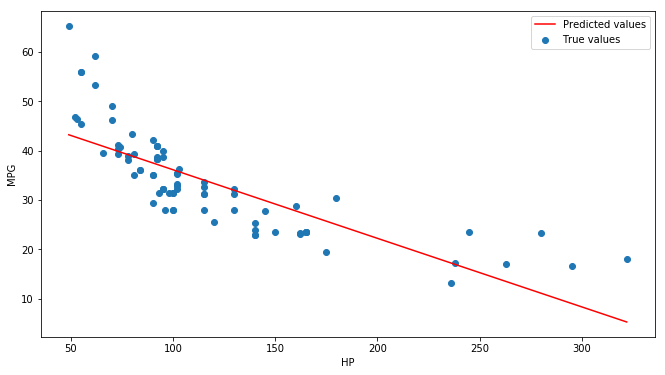

In [148]:
regr_lin, pred_lin = train_and_plot(x_data.values, y_data.values)

## (b)

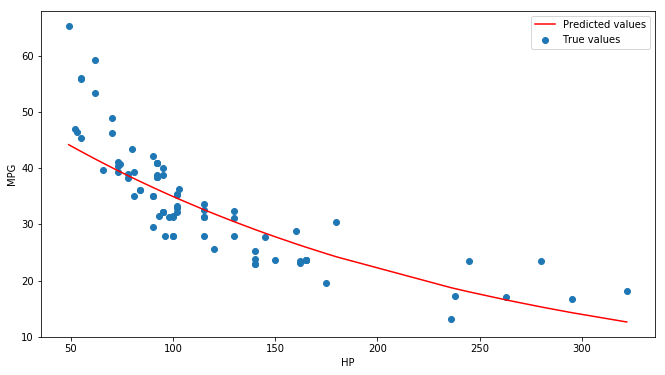

In [149]:
regr_log, pred_log = train_and_plot(x_data.values, y_data.values, np.log, np.exp)

In [150]:
def get_score(y_true, y_pred):
    return ((y_pred - y_true)**2).sum()

In [151]:
print('Качество чисто линейной модели %f' % get_score(y_data.values, pred_lin))
print('Качество линейной модели с логарифмическим признаком %f' % get_score(y_data.values, pred_log))

Качество чисто линейной модели 3049.435111
Качество линейной модели с логарифмическим признаком 2378.362675


__Качество заметно выросло__

## (c)

In [152]:
y_data = df['MPG']
x_data = df.drop('MPG', axis=1)

In [153]:
def fit_model(model, x_train, y_train):
    if len(x_train.shape) == 1:
        x_train = x_train.reshape((-1, 1))
    model.fit(x_train, y_train)
    return model

def predict_model(model, x_test):
    if len(x_test.shape) == 1:
        x_test = x_test.reshape((-1, 1))
    return model.predict(x_test)

In [154]:
model = fit_model(LinearRegression(), x_data, y_data)

In [155]:
print('Качество чисто линейной модели на всех признаках %f' % get_score(y_data.values, predict_model(model, x_data.values)))

Качество чисто линейной модели на всех признаках 1027.381477


## (d)

In [169]:
def fit_and_score(model, X, y):
    model = fit_model(model, X, y)
    y_pred = predict_model(model, X)
    return get_score(y, y_pred)
VAR = fit_and_score(LinearRegression(), x_data, y_data) / (x_data.shape[0] - x_data.shape[1])
print(VAR)
def get_mallow(x_train, y_train):
    features = x_train.shape[1] if len(x_train.shape) > 1 else 1
    return fit_and_score(LinearRegression(), x_train, y_train) + 2 * features * VAR

13.171557400703326


In [240]:
from itertools import product, combinations
from copy import deepcopy

def grid_search_features(x_data_df, y_data_df):
    x_data = x_data_df.values
    y_data = y_data_df.values
    
    features = x_data_df.columns
    status_bar = tqdm(total=2**len(features) - 1)
    best_score = None
    best_subfeatures = []
    for n_features in range(1, len(features) + 1):
        for selected_features in combinations(features, n_features):
            cols = list(selected_features)
            cur_score = get_mallow(x_data_df[cols].values, y_data)
            if best_score is None or cur_score < best_score:
                best_score = cur_score
                best_subfeatures = selected_features
            #print(cur_score, selected_features)
            status_bar.update()
    return best_subfeatures, best_score

def exclusive_search_features(x_data_df, y_data_df):
    x_data = x_data_df.values
    y_data = y_data_df.values
    
    features = x_data_df.columns.values
    best_score = get_mallow(x_data, y_data)
    best_subfeatures = deepcopy(features)
    
    found_better = True
    while found_better:
        subfeatures = [np.delete(best_subfeatures, i) for i in range(len(best_subfeatures))]
        scores = np.array([get_mallow(x_data_df[features], y_data) for features in subfeatures])
        min_ind = scores.argmin()
        if scores[min_ind] < best_score:
            best_subfeatures = subfeatures[min_ind]
            best_score = scores[min_ind]
            found_better = True
        else:
            found_better = False
    
    return best_subfeatures, best_score

def inclusive_search_features(x_data_df, y_data_df):
    x_data = x_data_df.values
    y_data = y_data_df.values
    
    features = x_data_df.columns.values
    best_score = None
    best_subfeatures = []
    best_subfeatures_set = set(best_subfeatures)
    rest_features = set(list(features))
    found_better = True
    while found_better:
        upfeatures = []
        for f in rest_features:
            new_features = deepcopy(best_subfeatures)
            new_features.append(f)
            upfeatures.append(new_features)
        scores = np.array([get_mallow(x_data_df[features], y_data) for features in upfeatures])
        min_ind = scores.argmin()
        if best_score is None or scores[min_ind] < best_score:
            best_subfeatures = upfeatures[min_ind]
            best_score = scores[min_ind]
            found_better = True
            rest_features -= set(upfeatures[min_ind])
        else:
            found_better = False
    return best_subfeatures, best_score

In [241]:
best_subfeatures, best_score = grid_search_features(x_data, y_data)
print( '{ '+ ', '.join(best_subfeatures) + ' } with score', best_score)


{ HP, SP, WT } with score 1112.6792828235086


In [242]:
best_subfeatures, best_score = exclusive_search_features(x_data, y_data)
print( '{ '+ ', '.join(best_subfeatures) + ' } with score', best_score)


{ HP, SP, WT } with score 1112.6792828235086


In [243]:
best_subfeatures, best_score = inclusive_search_features(x_data, y_data)
print( '{ '+ ', '.join(best_subfeatures) + ' } with score', best_score)


{ WT, SP, HP } with score 1112.6792828235066


##### Видим, что без признака VOL качество самое лучшее

# Задание 4

$$
AIC(S) = |S| - \ell_S
$$

Где $\ell_S$ -- логарифм правдоподобия модели, где в качестве неизвестных параметров были подставлены их оценки, полученные при максимизации $\ell_S\left(\beta\right)$ (Списал с презентации)

Распишем $\ell_S$:
$$
\ell_S = \ln \prod\dfrac{1}{2\pi}\exp\{\dfrac{y_j - \sum_{i=1}^{n} \beta_i x_{ji}}{2\sigma^2}\} = 
f(n, \sigma) -\sum \limits_{j=1}^{n} \frac{\left( y_j - \sum_{i=1}^{n} \beta_i x_{ji}\right)}{2\sigma^2} 
$$

Таким образом
$$
AIC(S) = |S| \sum \limits_{j=1}^{n} \frac{\left( y_j - \sum_{i=1}^{n} \beta_i x_{ji}\right)}{2\sigma^2} - f(n, \sigma)
$$
Заметим, что
$$
AIC \to min = 
$$

